# Assignment 4
Jan Widanka

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import pickle
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Loading cifar-10 dataset 

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
X_train.shape

(50000, 32, 32, 3)

In [5]:
X_test.shape

(10000, 32, 32, 3)

In [6]:
y_train.shape, y_test.shape

((50000, 1), (10000, 1))

In [15]:
#normalization
X_train, X_test = X_train / 255.0, X_test / 255.0

### Exploratory Data Analysis

In [8]:
class_names = unpickle('batches.meta')

In [9]:
class_names_list = []
for name in class_names[b'label_names']:
    class_names_list.append(str(name)[2:-1])

In [10]:
class_names_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

train_df = pd.DataFrame(np.column_stack((X_train_flat, y_train.flatten())), 
                        columns=[f"pixel_{i}" for i in range(X_train_flat.shape[1])] + ["class"])
test_df = pd.DataFrame(np.column_stack((X_test_flat, y_test.flatten())), 
                       columns=[f"pixel_{i}" for i in range(X_test_flat.shape[1])] + ["class"])

In [12]:
train_df['class'] = train_df['class'].map(dict(enumerate(class_names_list)))
test_df['class'] = test_df['class'].map(dict(enumerate(class_names_list)))

In [13]:
train_df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_3063,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,class
0,0.231373,0.243137,0.247059,0.168627,0.180392,0.176471,0.196078,0.188235,0.168627,0.266667,...,0.847059,0.721569,0.549020,0.592157,0.462745,0.329412,0.482353,0.360784,0.282353,frog
1,0.603922,0.694118,0.733333,0.494118,0.537255,0.533333,0.411765,0.407843,0.372549,0.400000,...,0.560784,0.521569,0.545098,0.560784,0.525490,0.556863,0.560784,0.521569,0.564706,truck
2,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.305882,0.333333,0.325490,0.309804,0.333333,0.325490,0.313725,0.337255,0.329412,truck
3,0.109804,0.098039,0.039216,0.145098,0.133333,0.074510,0.149020,0.137255,0.078431,0.164706,...,0.211765,0.184314,0.109804,0.247059,0.219608,0.145098,0.282353,0.254902,0.180392,deer
4,0.666667,0.705882,0.776471,0.658824,0.698039,0.768627,0.694118,0.725490,0.796078,0.717647,...,0.294118,0.309804,0.321569,0.278431,0.294118,0.305882,0.286275,0.301961,0.313725,automobile


In [14]:
test_df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_3063,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,class
0,0.619608,0.439216,0.192157,0.623529,0.435294,0.184314,0.647059,0.454902,0.200000,0.650980,...,0.094118,0.301961,0.486275,0.133333,0.329412,0.505882,0.082353,0.262745,0.431373,cat
1,0.921569,0.921569,0.921569,0.905882,0.905882,0.905882,0.909804,0.909804,0.909804,0.909804,...,0.658824,0.717647,0.698039,0.705882,0.764706,0.749020,0.729412,0.784314,0.780392,ship
2,0.619608,0.745098,0.870588,0.619608,0.733333,0.854902,0.545098,0.650980,0.760784,0.517647,...,0.019608,0.023529,0.031373,0.015686,0.019608,0.011765,0.027451,0.031373,0.027451,ship
3,0.607843,0.611765,0.584314,0.654902,0.690196,0.733333,0.690196,0.701961,0.756863,0.745098,...,0.235294,0.247059,0.196078,0.250980,0.254902,0.203922,0.286275,0.266667,0.196078,airplane
4,0.254902,0.266667,0.196078,0.274510,0.317647,0.250980,0.188235,0.250980,0.180392,0.117647,...,0.560784,0.701961,0.533333,0.603922,0.725490,0.572549,0.501961,0.611765,0.458824,frog


### Class distribution

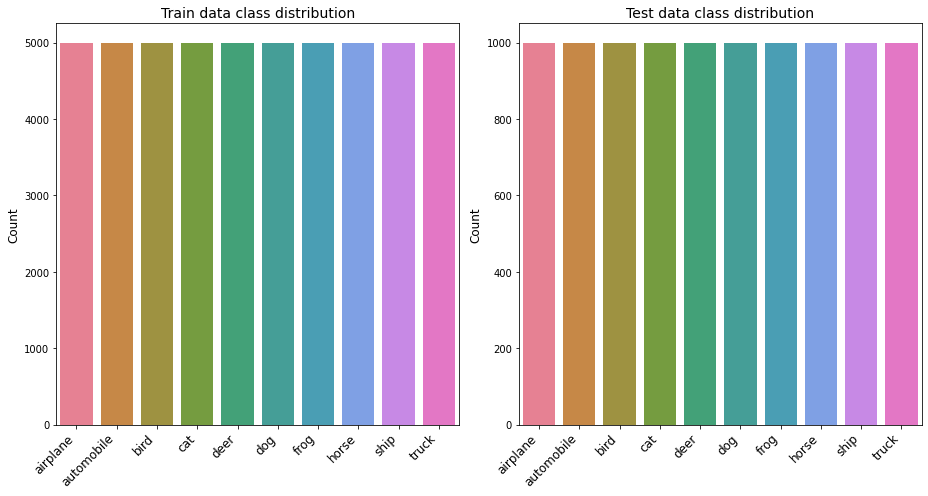

In [15]:
palette = sns.color_palette("husl", len(class_names_list))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

sns.countplot(y_train.flatten(), ax=axes[0], palette=palette)
axes[0].set_title("Train data class distribution", fontsize = 14)
axes[0].set_ylabel("Count", fontsize = 12)
axes[0].set_xticks(range(len(class_names_list)))
axes[0].set_xticklabels(class_names_list, rotation=45, ha='right', fontsize = 12)
sns.countplot(y_test.flatten(), ax=axes[1], palette=palette)
axes[1].set_title("Test data class distribution", fontsize = 14)
axes[1].set_ylabel("Count", fontsize = 12)
axes[1].set_xticks(range(len(class_names_list)))
axes[1].set_xticklabels(class_names_list, rotation=45, ha='right', fontsize = 12)
plt.tight_layout()
plt.show()

We can definetely say that there is no class imbalance problem in considered data set. 

### Checking the images

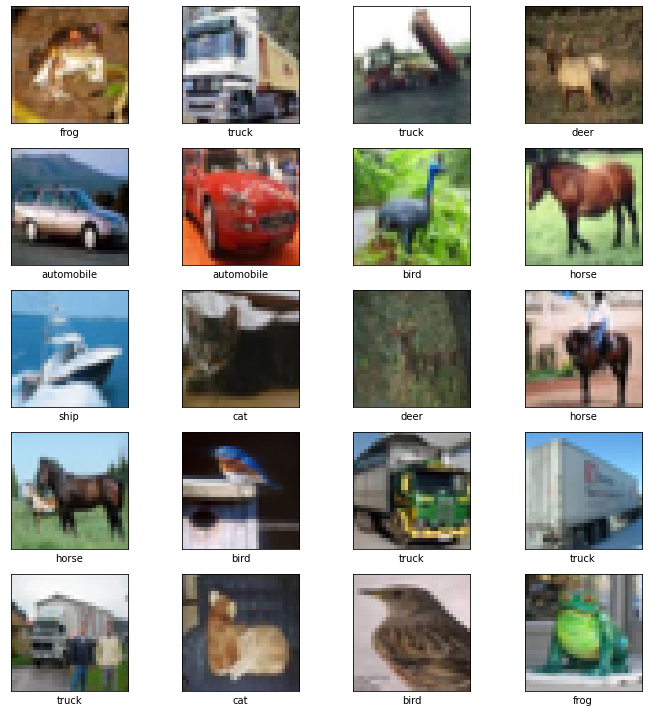

In [16]:
plt.figure(figsize=(10,10))

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i])
    plt.xlabel(class_names_list[y_train[i][0]])
plt.tight_layout()
plt.show()

### CNN

In [16]:
first_model = models.Sequential()

first_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
first_model.add(layers.MaxPool2D((2, 2)))

first_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
first_model.add(layers.MaxPool2D((2, 2)))
first_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [17]:
first_model.add(layers.Flatten())
first_model.add(layers.Dense(64, activation='relu'))
first_model.add(layers.Dense(10))

In [19]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [24]:
first_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [25]:
history = first_model.fit(X_train, y_train, 
                          epochs = 20,
                          batch_size = 32,
                          validation_data = (X_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 24s 15ms/step - loss: 1.5396 - accuracy: 0.4351 - val_loss: 1.2742 - val_accuracy: 0.5473
Epoch 2/20
1563/1563 [==============================] - 26s 16ms/step - loss: 1.1768 - accuracy: 0.5822 - val_loss: 1.0941 - val_accuracy: 0.6115
Epoch 3/20
1563/1563 [==============================] - 24s 15ms/step - loss: 1.0301 - accuracy: 0.6388 - val_loss: 1.0073 - val_accuracy: 0.6495
Epoch 4/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9396 - accuracy: 0.6708 - val_loss: 0.9581 - val_accuracy: 0.6654
Epoch 5/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8733 - accuracy: 0.6939 - val_loss: 0.9107 - val_accuracy: 0.6855
Epoch 6/20
1563/1563 [==============================] - 26s 16ms/step - loss: 0.8226 - accuracy: 0.7105 - val_loss: 0.9544 - val_accuracy: 0.6692
Epoch 7/20
1563/1563 [==============================] - 24s 15ms/step - loss: 0.7778 - accuracy: 0.7260 - val_loss: 0.8812 -

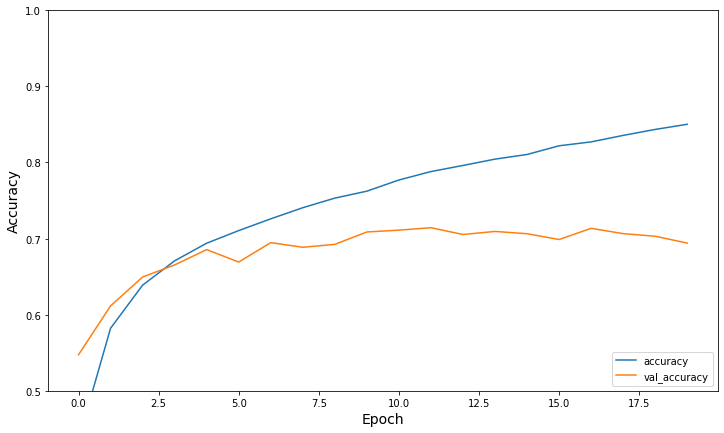

In [68]:
plt.figure(figsize = (12, 7))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [35]:
test_loss, test_acc = first_model.evaluate(X_test,  y_test, verbose=2)

313/313 - 1s - loss: 1.0475 - accuracy: 0.6941 - 1s/epoch - 4ms/step


In [36]:
print(test_acc)

0.694100022315979


In [37]:
first_model.save("first_model_cnn.keras")

### Confusion matrix

In [38]:
predictions = first_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_test, predicted_labels)

313/313 [==============================] - 1s 4ms/step


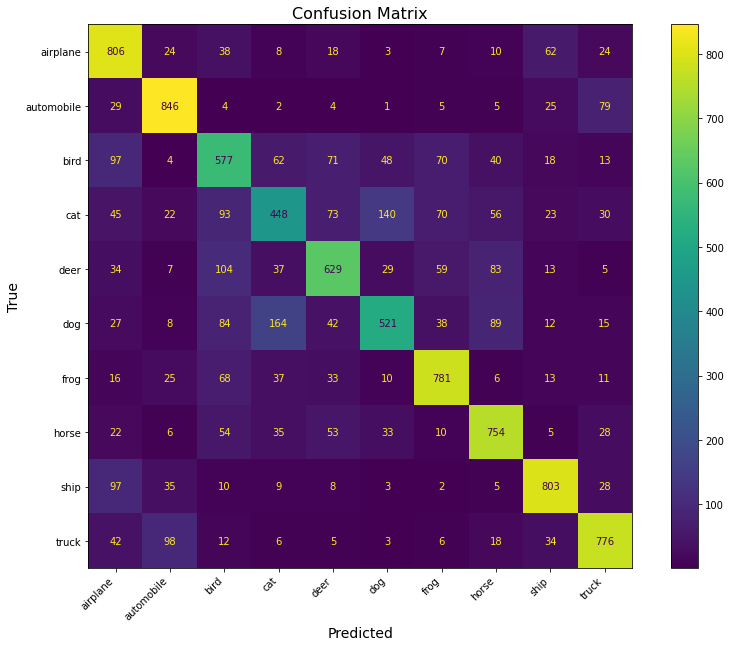

In [39]:
fig, ax = plt.subplots(figsize=(14, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                               display_labels=class_names_list)
disp.plot(ax = ax)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

### Classification report

In [40]:
print(classification_report(y_test, predicted_labels, target_names=class_names_list))

              precision    recall  f1-score   support

    airplane       0.66      0.81      0.73      1000
  automobile       0.79      0.85      0.82      1000
        bird       0.55      0.58      0.56      1000
         cat       0.55      0.45      0.50      1000
        deer       0.67      0.63      0.65      1000
         dog       0.66      0.52      0.58      1000
        frog       0.75      0.78      0.76      1000
       horse       0.71      0.75      0.73      1000
        ship       0.80      0.80      0.80      1000
       truck       0.77      0.78      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



### Second model

In [41]:
second_model = models.Sequential()
second_model.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
second_model.add(layers.MaxPool2D((2, 2)))
second_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
second_model.add(layers.MaxPool2D((2, 2)))
second_model.add(layers.Conv2D(128, (3, 3), activation='tanh'))

In [42]:
second_model.add(layers.Flatten())
second_model.add(layers.Dense(128, activation='tanh'))
second_model.add(layers.Dense(10, activation='softmax'))

In [43]:
second_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 2048)             

In [44]:
second_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_sec_model = second_model.fit(X_train, y_train,
                                     epochs=20, 
                                     batch_size = 32, 
                                     validation_data = (X_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 42s 26ms/step - loss: 1.4147 - accuracy: 0.4987 - val_loss: 1.2708 - val_accuracy: 0.5533
Epoch 2/20
1563/1563 [==============================] - 43s 28ms/step - loss: 1.1243 - accuracy: 0.6087 - val_loss: 1.0861 - val_accuracy: 0.6208
Epoch 3/20
1563/1563 [==============================] - 42s 27ms/step - loss: 1.0240 - accuracy: 0.6440 - val_loss: 1.0626 - val_accuracy: 0.6386
Epoch 4/20
1563/1563 [==============================] - 41s 26ms/step - loss: 0.9750 - accuracy: 0.6609 - val_loss: 1.0649 - val_accuracy: 0.6390
Epoch 5/20
1563/1563 [==============================] - 41s 26ms/step - loss: 0.9193 - accuracy: 0.6810 - val_loss: 1.0004 - val_accuracy: 0.6564
Epoch 6/20
1563/1563 [==============================] - 41s 26ms/step - loss: 0.8853 - accuracy: 0.6931 - val_loss: 0.9953 - val_accuracy: 0.6636
Epoch 7/20
1563/1563 [==============================] - 41s 26ms/step - loss: 0.8488 - accuracy: 0.7068 - val_loss: 0.9781 -

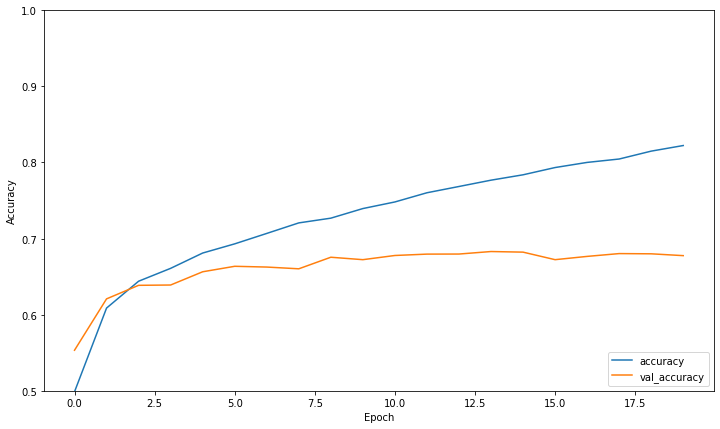

In [69]:
plt.figure(figsize = (12, 7))

plt.plot(history_sec_model.history['accuracy'], label='accuracy')
plt.plot(history_sec_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [46]:
test_loss_sec_mod, test_acc_sec_mod = second_model.evaluate(X_test,  y_test, verbose=2)

313/313 - 2s - loss: 1.0453 - accuracy: 0.6776 - 2s/epoch - 7ms/step


### Confusion matrix

In [47]:
predictions_tanh = second_model.predict(X_test)
predicted_labels_tanh = np.argmax(predictions_tanh, axis=1)

conf_matrix_sec_model = confusion_matrix(y_test, predicted_labels_tanh)

313/313 [==============================] - 2s 8ms/step


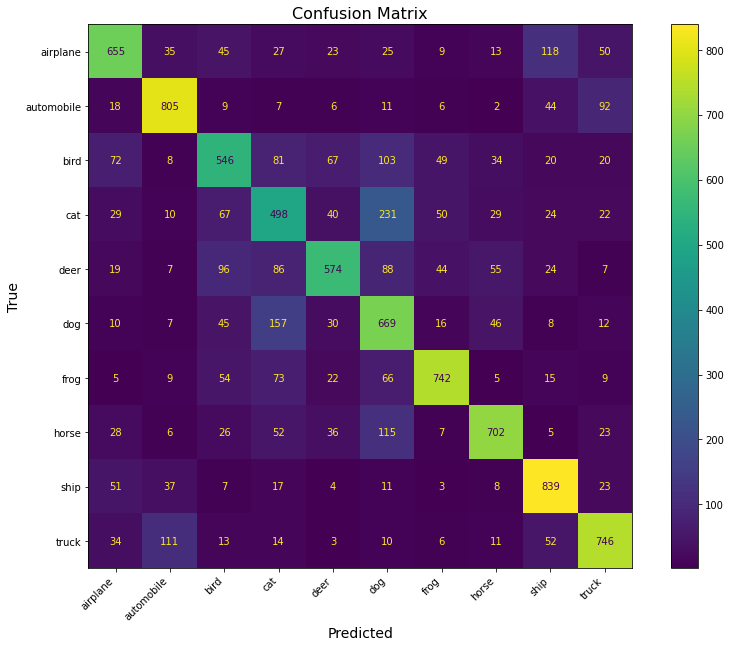

In [48]:
fig, ax = plt.subplots(figsize=(14, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_sec_model,
                               display_labels=class_names_list)
disp.plot(ax = ax)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

### Classification report

In [49]:
print(classification_report(y_test, predicted_labels_tanh, target_names=class_names_list))

              precision    recall  f1-score   support

    airplane       0.71      0.66      0.68      1000
  automobile       0.78      0.81      0.79      1000
        bird       0.60      0.55      0.57      1000
         cat       0.49      0.50      0.50      1000
        deer       0.71      0.57      0.64      1000
         dog       0.50      0.67      0.57      1000
        frog       0.80      0.74      0.77      1000
       horse       0.78      0.70      0.74      1000
        ship       0.73      0.84      0.78      1000
       truck       0.74      0.75      0.74      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



### Third model

In [50]:
third_model = models.Sequential()
third_model.add(layers.Conv2D(64, (4, 4), activation='relu', input_shape=(32, 32, 3)))
third_model.add(layers.MaxPool2D((2, 2)))
third_model.add(layers.Conv2D(64, (4, 4), activation='relu'))
third_model.add(layers.MaxPool2D((2, 2)))
third_model.add(layers.Conv2D(64, (4, 4), activation='relu'))

In [51]:
third_model.add(layers.Flatten())
third_model.add(layers.Dense(128, activation='relu'))
third_model.add(layers.Dense(10, activation='softmax'))

In [52]:
third_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 29, 29, 64)        3136      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        65600     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 2, 2, 64)          65600     
                                                                 
 flatten_3 (Flatten)         (None, 256)              

In [53]:
third_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

history_third_model = third_model.fit(X_train, y_train, 
                                      epochs = 20,
                                      batch_size = 32,
                                      validation_data = (X_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 42s 26ms/step - loss: 1.5655 - accuracy: 0.4258 - val_loss: 1.4004 - val_accuracy: 0.4987
Epoch 2/20
1563/1563 [==============================] - 40s 26ms/step - loss: 1.2280 - accuracy: 0.5624 - val_loss: 1.1377 - val_accuracy: 0.5973
Epoch 3/20
1563/1563 [==============================] - 40s 26ms/step - loss: 1.0848 - accuracy: 0.6173 - val_loss: 1.0810 - val_accuracy: 0.6220
Epoch 4/20
1563/1563 [==============================] - 44s 28ms/step - loss: 0.9898 - accuracy: 0.6539 - val_loss: 1.0302 - val_accuracy: 0.6371
Epoch 5/20
1563/1563 [==============================] - 42s 27ms/step - loss: 0.9169 - accuracy: 0.6792 - val_loss: 0.9921 - val_accuracy: 0.6609
Epoch 6/20
1563/1563 [==============================] - 43s 28ms/step - loss: 0.8550 - accuracy: 0.7012 - val_loss: 0.9751 - val_accuracy: 0.6638
Epoch 7/20
1563/1563 [==============================] - 39s 25ms/step - loss: 0.8041 - accuracy: 0.7195 - val_loss: 0.9539 -

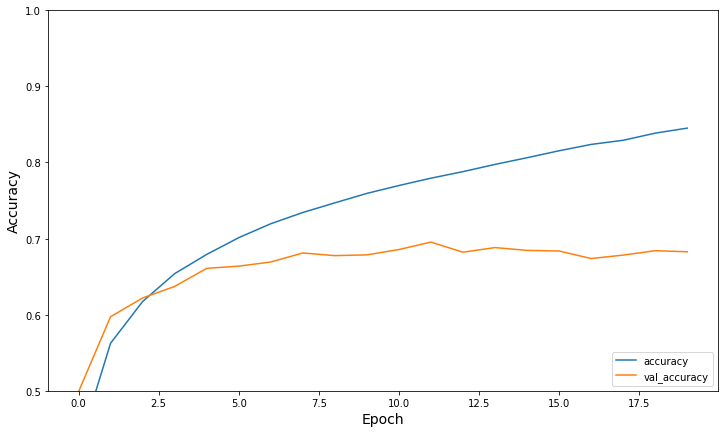

In [54]:
plt.figure(figsize= (12,7))

plt.plot(history_third_model.history['accuracy'], label='accuracy')
plt.plot(history_third_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [55]:
predictions_third = third_model.predict(X_test)
predicted_labels_third = np.argmax(predictions_third, axis=1)

conf_matrix_third_model = confusion_matrix(y_test, predicted_labels_third)

313/313 [==============================] - 2s 7ms/step


### Confusion matrix

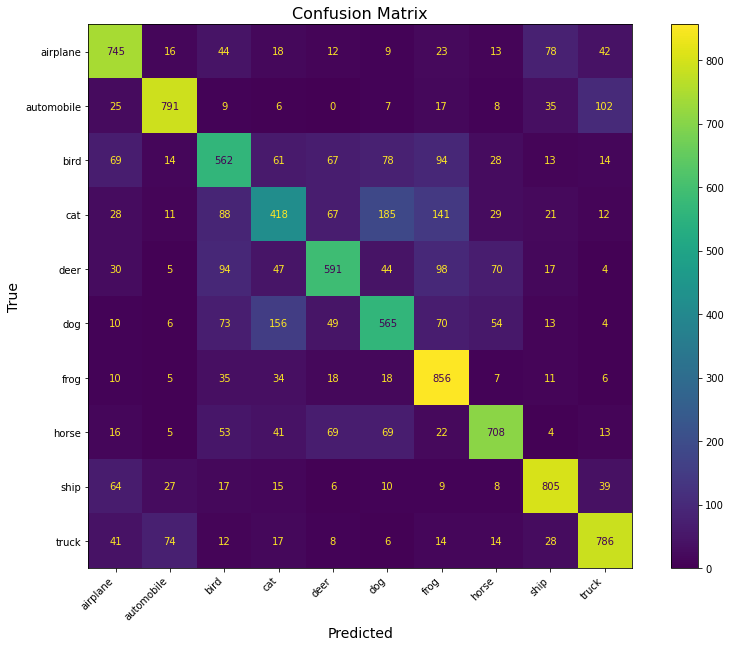

In [56]:
fig, ax = plt.subplots(figsize=(14, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_third_model,
                               display_labels=class_names_list)
disp.plot(ax = ax)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

### Classification report

In [57]:
print(classification_report(y_test, predicted_labels_third, target_names=class_names_list))

              precision    recall  f1-score   support

    airplane       0.72      0.74      0.73      1000
  automobile       0.83      0.79      0.81      1000
        bird       0.57      0.56      0.57      1000
         cat       0.51      0.42      0.46      1000
        deer       0.67      0.59      0.63      1000
         dog       0.57      0.56      0.57      1000
        frog       0.64      0.86      0.73      1000
       horse       0.75      0.71      0.73      1000
        ship       0.79      0.81      0.80      1000
       truck       0.77      0.79      0.78      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



### Tuning

In [22]:
def cnn_model(activation='relu'):
    cnn_model = models.Sequential()
    
    cnn_model.add(layers.Conv2D(32, (3, 3), activation=activation, input_shape=(32, 32, 3)))
    cnn_model.add(layers.MaxPool2D((2, 2)))
    
    cnn_model.add(layers.Conv2D(64, (3, 3), activation=activation))
    cnn_model.add(layers.MaxPool2D((2, 2)))

    cnn_model.add(layers.Conv2D(64, (3, 3), activation=activation))
    
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(10, activation=activation))

    cnn_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    return cnn_model

In [23]:
keras_model = KerasClassifier(build_fn=cnn_model, epochs=10, batch_size=32, verbose=0)

In [25]:
param_grid = {
    #'optimizer': ['adam', 'sgd', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
    #'optimizer__learning_rate ': [0.001, 0.01, 0.1]
}

In [26]:
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, scoring='accuracy', cv=3)

In [27]:
grid_result = grid_search.fit(X_train, y_train)

In [28]:
best_params = grid_result.best_params_

In [29]:
print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'batch_size': 64, 'epochs': 10}


In [38]:
print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'batch_size': 64, 'epochs': 10, 'optimizer__learning_rate ': 0.01}


In [60]:
print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'batch_size': 64, 'epochs': 10, 'optimizer': 'adam'}


## Tuned model

In [23]:
tuned_model = models.Sequential()

tuned_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
tuned_model.add(layers.MaxPool2D((2, 2)))

tuned_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
tuned_model.add(layers.MaxPool2D((2, 2)))
tuned_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [24]:
tuned_model.add(layers.Flatten())
tuned_model.add(layers.Dense(64, activation='relu'))
tuned_model.add(layers.Dense(10))

In [25]:
tuned_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [26]:
history_tuned_model = tuned_model.fit(X_train, y_train, 
                                      epochs = 10, 
                                      batch_size = 64,
                                      validation_data = (X_test, y_test))

Epoch 1/10
782/782 [==============================] - 25s 30ms/step - loss: 1.5559 - accuracy: 0.4291 - val_loss: 1.2960 - val_accuracy: 0.5273
Epoch 2/10
782/782 [==============================] - 25s 32ms/step - loss: 1.2051 - accuracy: 0.5709 - val_loss: 1.1210 - val_accuracy: 0.6013
Epoch 3/10
782/782 [==============================] - 23s 30ms/step - loss: 1.0549 - accuracy: 0.6293 - val_loss: 1.0941 - val_accuracy: 0.6228
Epoch 4/10
782/782 [==============================] - 22s 28ms/step - loss: 0.9522 - accuracy: 0.6668 - val_loss: 0.9605 - val_accuracy: 0.6615
Epoch 5/10
782/782 [==============================] - 19s 24ms/step - loss: 0.8692 - accuracy: 0.6979 - val_loss: 0.8860 - val_accuracy: 0.6911
Epoch 6/10
782/782 [==============================] - 19s 24ms/step - loss: 0.8039 - accuracy: 0.7193 - val_loss: 0.9113 - val_accuracy: 0.6854
Epoch 7/10
782/782 [==============================] - 19s 24ms/step - loss: 0.7526 - accuracy: 0.7363 - val_loss: 0.8716 - val_accuracy:

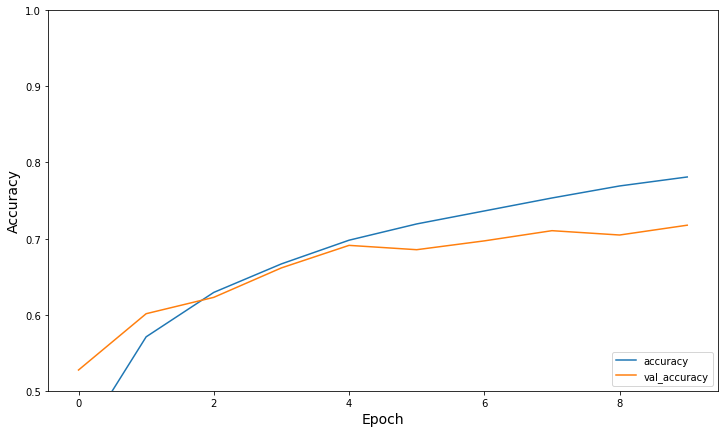

In [27]:
plt.figure(figsize= (12,7))

plt.plot(history_tuned_model.history['accuracy'], label='accuracy')
plt.plot(history_tuned_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [28]:
test_loss_tuned, test_acc_tuned = tuned_model.evaluate(X_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.8345 - accuracy: 0.7176 - 1s/epoch - 4ms/step


In [29]:
predictions_tuned = tuned_model.predict(X_test)
predicted_labels_tuned = np.argmax(predictions_tuned, axis=1)

conf_matrix_tuned_model = confusion_matrix(y_test, predicted_labels_tuned)

313/313 [==============================] - 1s 4ms/step


### Confusion matrix

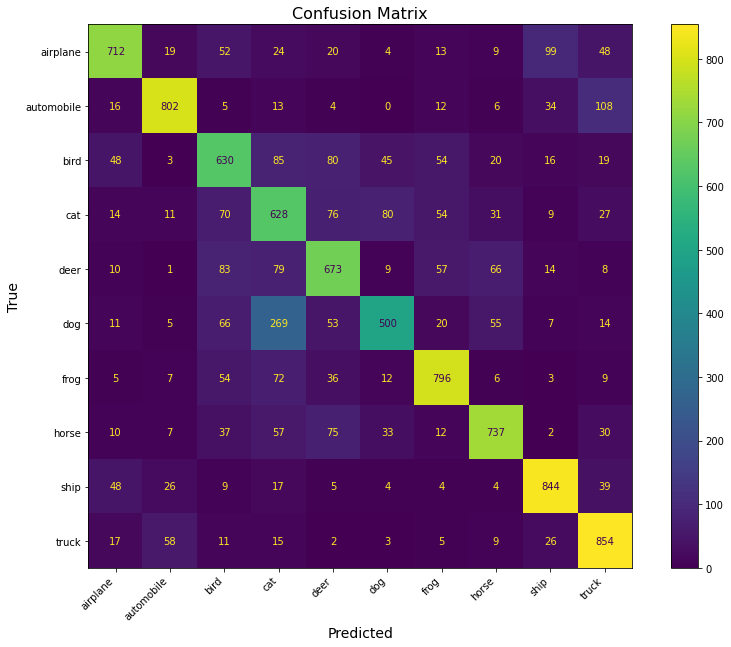

In [30]:
fig, ax = plt.subplots(figsize=(14, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tuned_model,
                               display_labels=class_names_list)
disp.plot(ax = ax)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

### Classification report

In [31]:
print(classification_report(y_test, predicted_labels_tuned, target_names=class_names_list))

              precision    recall  f1-score   support

    airplane       0.80      0.71      0.75      1000
  automobile       0.85      0.80      0.83      1000
        bird       0.62      0.63      0.62      1000
         cat       0.50      0.63      0.56      1000
        deer       0.66      0.67      0.67      1000
         dog       0.72      0.50      0.59      1000
        frog       0.78      0.80      0.79      1000
       horse       0.78      0.74      0.76      1000
        ship       0.80      0.84      0.82      1000
       truck       0.74      0.85      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



## Augmenting

In [7]:
datagen = ImageDataGenerator(
                    rotation_range = 20,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True
)

In [8]:
datagen.fit(X_train)

### Plot augmented

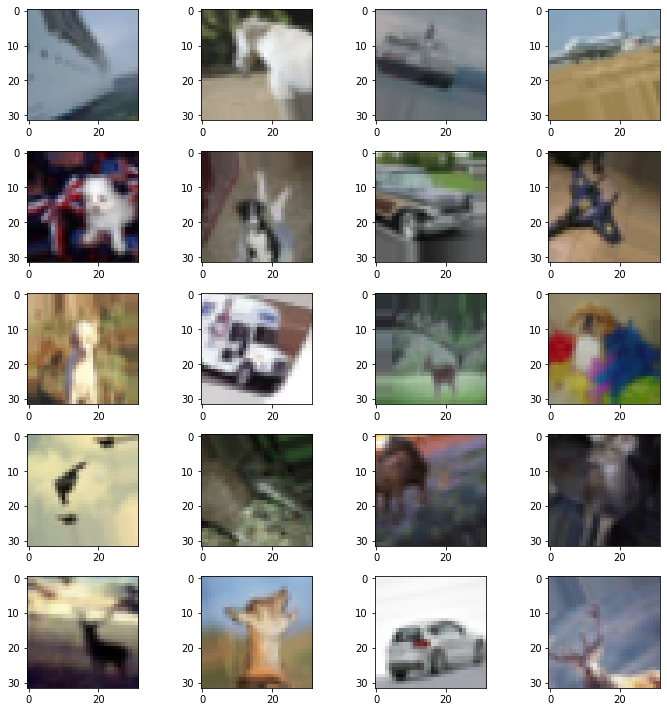

In [10]:
plt.figure(figsize=(10, 10))

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 32):
    for i in range(20):
        plt.subplot(5, 4, i + 1)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.tight_layout()
    plt.show()
    break

#### Normalization for augmentation

In [9]:
mean = np.mean(X_train)
std = np.std(X_train)
X_test_aug = (X_test - mean) / std
X_train_aug = (X_train - mean) / std

In [10]:
X_test_aug.shape, X_train_aug.shape

((10000, 32, 32, 3), (50000, 32, 32, 3))

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Comparizon with first model

In [11]:
model_aug = models.Sequential()

model_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_aug.add(MaxPool2D((2, 2)))

model_aug.add(Conv2D(64, (3, 3), activation='relu'))
model_aug.add(MaxPool2D((2, 2)))
model_aug.add(Conv2D(64, (3, 3), activation='relu'))

model_aug.add(Flatten())
model_aug.add(Dense(64, activation='relu'))
model_aug.add(Dense(10, activation='softmax'))

In [12]:
model_aug.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [22]:
history_augmented = model_aug.fit(
                        datagen.flow(X_train_aug, y_train, batch_size = 32),
                        epochs = 20,
                        validation_data = (X_test_aug, y_test)
)

Epoch 1/20
1563/1563 [==============================] - 32s 20ms/step - loss: 1.6864 - accuracy: 0.3798 - val_loss: 1.3254 - val_accuracy: 0.5289
Epoch 2/20
1563/1563 [==============================] - 48s 31ms/step - loss: 1.4105 - accuracy: 0.4909 - val_loss: 1.2471 - val_accuracy: 0.5599
Epoch 3/20
1563/1563 [==============================] - 49s 32ms/step - loss: 1.2867 - accuracy: 0.5387 - val_loss: 1.1805 - val_accuracy: 0.5886
Epoch 4/20
1563/1563 [==============================] - 47s 30ms/step - loss: 1.2137 - accuracy: 0.5687 - val_loss: 1.0164 - val_accuracy: 0.6434
Epoch 5/20
1563/1563 [==============================] - 45s 29ms/step - loss: 1.1550 - accuracy: 0.5903 - val_loss: 0.9956 - val_accuracy: 0.6532
Epoch 6/20
1563/1563 [==============================] - 46s 29ms/step - loss: 1.1208 - accuracy: 0.6016 - val_loss: 0.9936 - val_accuracy: 0.6623
Epoch 7/20
1563/1563 [==============================] - 57s 36ms/step - loss: 1.0896 - accuracy: 0.6153 - val_loss: 0.8995 -

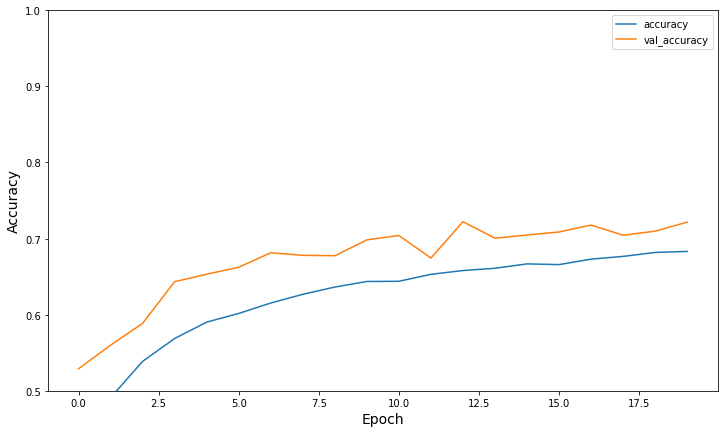

In [37]:
plt.figure(figsize= (12,7))

plt.plot(history_augmented.history['accuracy'], label='accuracy')
plt.plot(history_augmented.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.show()

## Second model comparizon

In [25]:
model_aug_sec = models.Sequential()
model_aug_sec.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
model_aug_sec.add(layers.MaxPool2D((2, 2)))

model_aug_sec.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model_aug_sec.add(layers.MaxPool2D((2, 2)))
model_aug_sec.add(layers.Conv2D(128, (3, 3), activation='tanh'))

In [26]:
model_aug_sec.add(layers.Flatten())
model_aug_sec.add(layers.Dense(128, activation='tanh'))
model_aug_sec.add(layers.Dense(10, activation='softmax'))

In [27]:
model_aug_sec.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [29]:
history_augmented_sec = model_aug_sec.fit(
                        datagen.flow(X_train_aug, y_train, batch_size = 32),
                        epochs = 20,
                        validation_data = (X_test_aug, y_test)
)

Epoch 1/20
1563/1563 [==============================] - 49s 31ms/step - loss: 1.5334 - accuracy: 0.4507 - val_loss: 1.3434 - val_accuracy: 0.5194
Epoch 2/20
1563/1563 [==============================] - 65s 42ms/step - loss: 1.4718 - accuracy: 0.4738 - val_loss: 1.2302 - val_accuracy: 0.5560
Epoch 3/20
1563/1563 [==============================] - 58s 37ms/step - loss: 1.4298 - accuracy: 0.4900 - val_loss: 1.2773 - val_accuracy: 0.5426
Epoch 4/20
1563/1563 [==============================] - 64s 41ms/step - loss: 1.4004 - accuracy: 0.5004 - val_loss: 1.2824 - val_accuracy: 0.5522
Epoch 5/20
1563/1563 [==============================] - 57s 36ms/step - loss: 1.3721 - accuracy: 0.5137 - val_loss: 1.1994 - val_accuracy: 0.5730
Epoch 6/20
1563/1563 [==============================] - 56s 36ms/step - loss: 1.3417 - accuracy: 0.5191 - val_loss: 1.1465 - val_accuracy: 0.5946
Epoch 7/20
1563/1563 [==============================] - 56s 36ms/step - loss: 1.3239 - accuracy: 0.5305 - val_loss: 1.1059 -

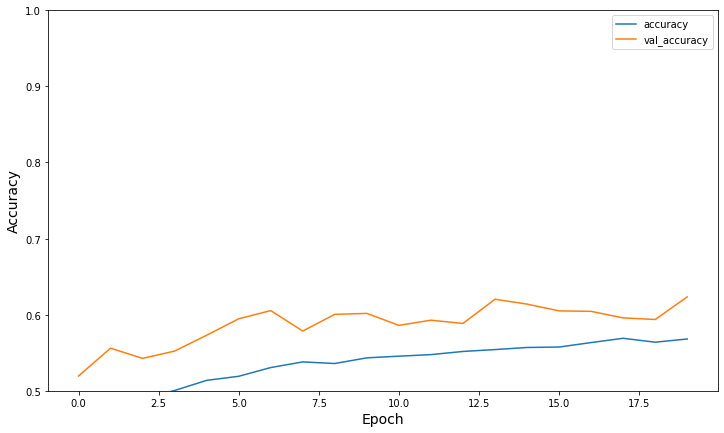

In [36]:
plt.figure(figsize= (12,7))

plt.plot(history_augmented_sec.history['accuracy'], label='accuracy')
plt.plot(history_augmented_sec.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.show()

## Third model comparizon

In [31]:
model_aug_2 = models.Sequential()
model_aug_2.add(layers.Conv2D(64, (4, 4), activation='relu', input_shape=(32, 32, 3)))
model_aug_2.add(layers.MaxPool2D((2, 2)))
model_aug_2.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_aug_2.add(layers.MaxPool2D((2, 2)))
model_aug_2.add(layers.Conv2D(64, (4, 4), activation='relu'))

In [32]:
model_aug_2.add(layers.Flatten())
model_aug_2.add(layers.Dense(128, activation='relu'))
model_aug_2.add(layers.Dense(10, activation='softmax'))

In [33]:
model_aug_2.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [34]:
history_augmented_2 = model_aug_2.fit(
                        datagen.flow(X_train_aug, y_train, batch_size = 32),
                        epochs = 20,
                        validation_data=(X_test_aug, y_test))

Epoch 1/20
1563/1563 [==============================] - 66s 41ms/step - loss: 1.7472 - accuracy: 0.3556 - val_loss: 1.3622 - val_accuracy: 0.4970
Epoch 2/20
1563/1563 [==============================] - 63s 40ms/step - loss: 1.4902 - accuracy: 0.4629 - val_loss: 1.2836 - val_accuracy: 0.5284
Epoch 3/20
1563/1563 [==============================] - 59s 38ms/step - loss: 1.3876 - accuracy: 0.5024 - val_loss: 1.2220 - val_accuracy: 0.5693
Epoch 4/20
1563/1563 [==============================] - 54s 35ms/step - loss: 1.3301 - accuracy: 0.5249 - val_loss: 1.2527 - val_accuracy: 0.5667
Epoch 5/20
1563/1563 [==============================] - 54s 34ms/step - loss: 1.2769 - accuracy: 0.5474 - val_loss: 1.1128 - val_accuracy: 0.6089
Epoch 6/20
1563/1563 [==============================] - 57s 36ms/step - loss: 1.2418 - accuracy: 0.5599 - val_loss: 1.0444 - val_accuracy: 0.6280
Epoch 7/20
1563/1563 [==============================] - 59s 38ms/step - loss: 1.2082 - accuracy: 0.5714 - val_loss: 1.0995 -

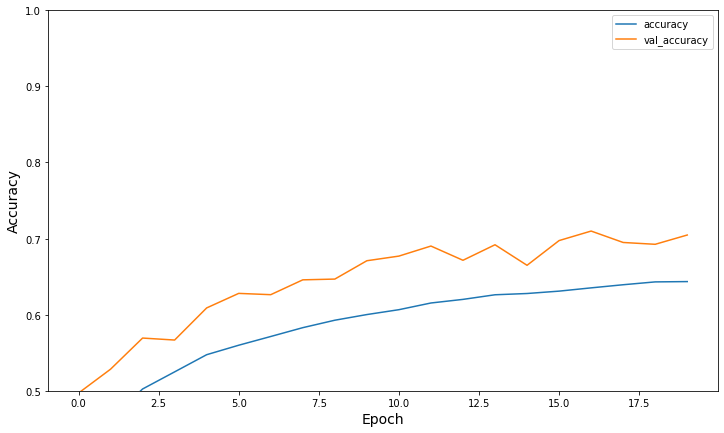

In [38]:
plt.figure(figsize= (12,7))

plt.plot(history_augmented_2.history['accuracy'], label='accuracy')
plt.plot(history_augmented_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.show()

### Augmented more epochs

In [12]:
model_aug_more_epochs = models.Sequential()

model_aug_more_epochs.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_aug_more_epochs.add(MaxPool2D((2, 2)))

model_aug_more_epochs.add(Conv2D(64, (3, 3), activation='relu'))
model_aug_more_epochs.add(MaxPool2D((2, 2)))
model_aug_more_epochs.add(Conv2D(64, (3, 3), activation='relu'))

model_aug_more_epochs.add(Flatten())
model_aug_more_epochs.add(Dense(64, activation='relu'))
model_aug_more_epochs.add(Dense(10, activation='softmax'))

In [13]:
model_aug_more_epochs.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [14]:
history_augmented_more_epochs = model_aug_more_epochs.fit(
                        datagen.flow(X_train_aug, y_train, batch_size = 32),
                        epochs = 40,
                        validation_data = (X_test_aug, y_test)
)

Epoch 1/40


1563/1563 [==============================] - 35s 22ms/step - loss: 1.6920 - accuracy: 0.3805 - val_loss: 1.3990 - val_accuracy: 0.5012
Epoch 2/40
1563/1563 [==============================] - 53s 34ms/step - loss: 1.4093 - accuracy: 0.4913 - val_loss: 1.1249 - val_accuracy: 0.5961
Epoch 3/40
1563/1563 [==============================] - 89s 57ms/step - loss: 1.3027 - accuracy: 0.5339 - val_loss: 1.1724 - val_accuracy: 0.5932
Epoch 4/40
1563/1563 [==============================] - 120s 77ms/step - loss: 1.2306 - accuracy: 0.5610 - val_loss: 1.0418 - val_accuracy: 0.6396
Epoch 5/40
1563/1563 [==============================] - 118s 75ms/step - loss: 1.1811 - accuracy: 0.5810 - val_loss: 1.0712 - val_accuracy: 0.6353
Epoch 6/40
1563/1563 [==============================] - 128s 82ms/step - loss: 1.1432 - accuracy: 0.5940 - val_loss: 1.0658 - val_accuracy: 0.6340
Epoch 7/40
1563/1563 [==============================] - 131s 84ms/step - loss: 1.1021 - accuracy: 0.6094 - val_loss: 1.

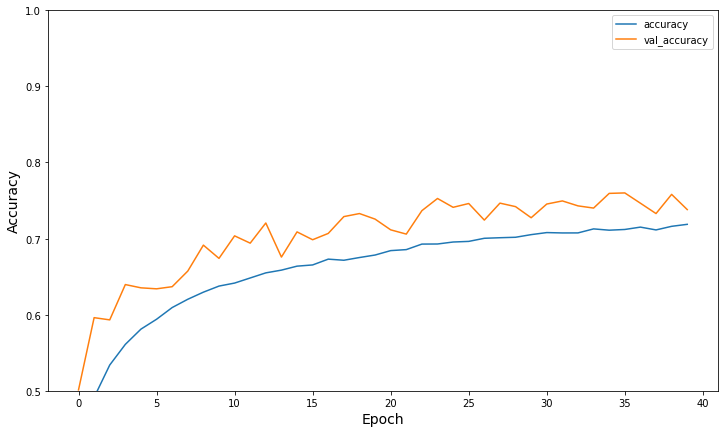

In [15]:
plt.figure(figsize= (12,7))

plt.plot(history_augmented_more_epochs.history['accuracy'], label='accuracy')
plt.plot(history_augmented_more_epochs.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.show()

## AlexNet

In [80]:
def AlexNet_cifar(input_shape=(32, 32, 3), num_classes = 10):
    alex_model = models.Sequential()

    alex_model.add(Conv2D(filters = 96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape = input_shape))
    alex_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

    alex_model.add(Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same'))
    alex_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

    alex_model.add(Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same'))

    alex_model.add(Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same'))

    alex_model.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same'))
    alex_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

    alex_model.add(Flatten())

    alex_model.add(Dense(4096, activation='relu'))
    alex_model.add(Dropout(0.5))

    alex_model.add(Dense(4096, activation='relu'))
    alex_model.add(Dropout(0.5))

    alex_model.add(Dense(num_classes))

    return alex_model

In [81]:
#should be input_shape = (224, 224, 3)
alex_model_cif = AlexNet_cifar()

In [82]:
alex_model_cif.compile(optimizer='adam', 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

In [ ]:
history_alex_net = alex_model_cif.fit(X_train, y_train, 
                                      epochs = 10,
                                      batch_size = 32,
                                      validation_data = (X_test, y_test))

Epoch 1/10
704/704 [==============================] - 771s 1s/step - loss: 12.3741 - accuracy: 0.1000 - val_loss: 14.5288 - val_accuracy: 0.0986
Epoch 2/10
704/704 [==============================] - 765s 1s/step - loss: 9.1801 - accuracy: 0.1002 - val_loss: 14.5288 - val_accuracy: 0.0986
Epoch 3/10
704/704 [==============================] - 769s 1s/step - loss: 9.2007 - accuracy: 0.1002 - val_loss: 14.5288 - val_accuracy: 0.0986
Epoch 4/10
704/704 [==============================] - 812s 1s/step - loss: 9.2168 - accuracy: 0.1002 - val_loss: 14.5288 - val_accuracy: 0.0986
Epoch 5/10
704/704 [==============================] - 774s 1s/step - loss: 9.1869 - accuracy: 0.1002 - val_loss: 14.5288 - val_accuracy: 0.0986
Epoch 6/10
704/704 [==============================] - 774s 1s/step - loss: 9.2078 - accuracy: 0.1001 - val_loss: 14.5288 - val_accuracy: 0.0986
Epoch 7/10
704/704 [==============================] - 773s 1s/step - loss: 9.2540 - accuracy: 0.1002 - val_loss: 14.5288 - val_accuracy

In [ ]:
plt.figure(figsize= (12,7))

plt.plot(history_alex_net.history['accuracy'], label='accuracy')
plt.plot(history_alex_net.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
predictions_alex_net = vgg_16_cifar.predict(X_test)
predicted_labels_alex_net = np.argmax(predictions_alex_net, axis=1)

conf_matrix_alex_net_model = confusion_matrix(y_test, predicted_labels_alex_net)

### Confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_alex_net_model,
                               display_labels=class_names_list)
disp.plot(ax = ax)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

### Classification report

In [ ]:
print(classification_report(y_test, predicted_labels_alex_net, target_names=class_names_list))

## LeNet

In [26]:
def leNet(input_shape=(32, 32, 3)):
    lenet_model = models.Sequential()

    lenet_model.add(Conv2D(6, (5, 5), activation='sigmoid', input_shape=input_shape, padding='same'))
    lenet_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    lenet_model.add(Conv2D(16, (5, 5), activation='sigmoid'))
    lenet_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    lenet_model.add(Flatten())

    lenet_model.add(Dense(120, activation='sigmoid'))
    lenet_model.add(Dense(84, activation='sigmoid'))

    lenet_model.add(Dense(10))

    return lenet_model

In [27]:
lenet_model_cif = leNet()

In [28]:
lenet_model_cif.compile(optimizer='adam', 
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

In [29]:
history_lenet = lenet_model_cif.fit(X_train, y_train, 
                                    epochs = 20,
                                    batch_size = 32,
                                    validation_data = (X_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 11s 6ms/step - loss: 2.0138 - accuracy: 0.2485 - val_loss: 1.8477 - val_accuracy: 0.3168
Epoch 2/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7413 - accuracy: 0.3670 - val_loss: 1.6589 - val_accuracy: 0.3936
Epoch 3/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6076 - accuracy: 0.4169 - val_loss: 1.5462 - val_accuracy: 0.4348
Epoch 4/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5246 - accuracy: 0.4440 - val_loss: 1.4825 - val_accuracy: 0.4565
Epoch 5/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.4589 - accuracy: 0.4675 - val_loss: 1.4702 - val_accuracy: 0.4626
Epoch 6/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.4070 - accuracy: 0.4882 - val_loss: 1.3854 - val_accuracy: 0.4893
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3526 - accuracy: 0.5088 - val_loss: 1.3537 - val_ac

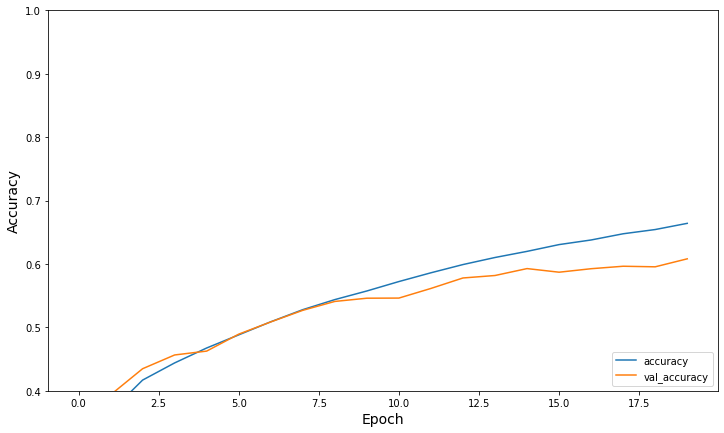

In [30]:
plt.figure(figsize= (12,7))

plt.plot(history_lenet.history['accuracy'], label='accuracy')
plt.plot(history_lenet.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.ylim([0.4, 1])
plt.legend(loc='lower right')
plt.show()

In [31]:
predictions_lenet = lenet_model_cif.predict(X_test)
predicted_labels_lenet = np.argmax(predictions_lenet, axis=1)

conf_matrix_lenet_model = confusion_matrix(y_test, predicted_labels_lenet)

313/313 [==============================] - 1s 2ms/step


### Confusion matrix

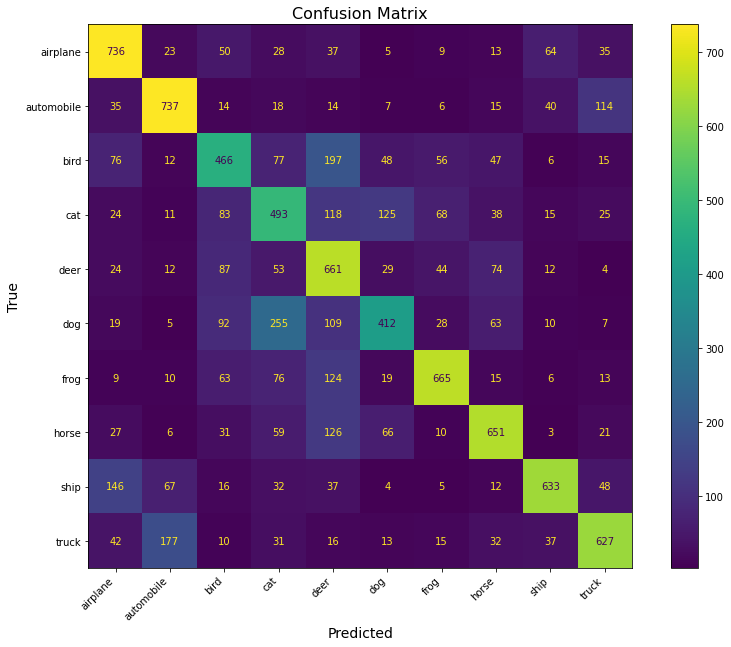

In [32]:
fig, ax = plt.subplots(figsize=(14, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lenet_model,
                               display_labels=class_names_list)
disp.plot(ax = ax)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

### Classification report

In [33]:
print(classification_report(y_test, predicted_labels_lenet, target_names=class_names_list))

              precision    recall  f1-score   support

    airplane       0.65      0.74      0.69      1000
  automobile       0.70      0.74      0.72      1000
        bird       0.51      0.47      0.49      1000
         cat       0.44      0.49      0.46      1000
        deer       0.46      0.66      0.54      1000
         dog       0.57      0.41      0.48      1000
        frog       0.73      0.67      0.70      1000
       horse       0.68      0.65      0.66      1000
        ship       0.77      0.63      0.69      1000
       truck       0.69      0.63      0.66      1000

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.62      0.61      0.61     10000

